In [7]:
#!/usr/bin/env python
# coding: utf-8

# In[17]:


from __future__ import print_function
import sys, os, glob, datetime, shutil, traceback, requests
from keras.callbacks import LambdaCallback, Callback, ModelCheckpoint, CSVLogger
from keras.models import Sequential, load_model
from keras.layers import LSTM, CuDNNLSTM, Dense, Dropout
from keras.optimizers import RMSprop, Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras import metrics
from keras.utils.data_utils import get_file
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 


# In[18]:


from numpy.random import seed
from tensorflow import set_random_seed

seed(1)
set_random_seed(2)

sys.version

files = glob.glob('/home/ubuntu')
is_aws = len(files)


def load_data(filename):
    dataset = pd.read_csv(filename)
    dataset.loc[:, 'time2'] = pd.to_datetime(dataset.loc[:, 'time2'])
    return dataset

def prepare_data(dataset, train_params):
    n_train, n_val, n_test = train_params['n_train'], train_params['n_val'], train_params['n_test']
    serie_len, serie_y_len, sample_step_size = train_params['serie_len'], train_params['serie_y_len'], train_params['sample_step_size']
#     train = dataset.loc[0:500000]
    train = dataset.sort_values("time")

    params_len = len(train.columns)

    avg_s = "avg" + str(serie_y_len)
    per_s = "per" + str(serie_y_len)
    avg_per_s = "avg_per" + str(serie_y_len)

    train.loc[:, avg_s] = train["price_close"].rolling(serie_y_len).mean()
    train.loc[:, per_s] = train[avg_s].pct_change(serie_y_len) * 100
    train.loc[:, avg_per_s] = train[per_s].rolling(serie_y_len).mean()
    train = train.dropna()
    train = train.reset_index()
    
    input_fields = ('price_open', 'price_high',
           'price_low', 'price_close', 'sdelki_sum', 'sdelki_b05', 'sdelki_b4',
           'sdelki_b20', 'sdelki_b40', 'sdelki_b110', 'sdelki_b999', 'sdelki_s05',
           'sdelki_s4', 'sdelki_s20', 'sdelki_s40', 'sdelki_s110', 'sdelki_s999',
           'sdelki_pb05', 'sdelki_pb4', 'sdelki_pb20', 'sdelki_pb40',
           'sdelki_pb110', 'sdelki_pb999', 'sdelki_ps05', 'sdelki_ps4',
           'sdelki_ps20', 'sdelki_ps40', 'sdelki_ps110', 'sdelki_ps999')
    train_features = train.loc[:, input_fields]

    # Normalization
    sc = MinMaxScaler(feature_range=(0,1))
    train_features = sc.fit_transform(train_features)
    
    series = []
    series_y = []

    for i in range(0, len(train_features) - serie_len - serie_y_len, sample_step_size):
        series.append(train_features[i: i + serie_len])
        series_y.append(train.loc[i + serie_len + serie_y_len, avg_per_s])
    
    x = np.zeros((len(series), serie_len, train_features.shape[1]))
    y = np.zeros((len(series), 1))
    
    for i, serie in enumerate(series):
        x[i] = serie
        y[i] = series_y[i]
    
    print('x.shape: ', x.shape)
    
#     np.random.seed(0)
#     perm = np.random.permutation(n_train + n_val)
    perm = [0,2,1]
    data_x = np.array(np.split(x, [45000, 55000]))
    data_x = np.concatenate(data_x[perm])
    data_y = np.array(np.split(y, [45000, 55000]))
    data_y = np.concatenate(data_y[perm])
    print('samples size', x.shape)

    train_x, train_y = data_x[:-n_val-n_test], data_y[:-n_val-n_test]
    val_x, val_y = data_x[-n_val-n_test:-n_test], data_y[-n_val-n_test:-n_test]
    test_x, test_y = data_x[-n_test:], data_y[-n_test:]
    
    return train_x, train_y, val_x, val_y, test_x, test_y


# In[22]:


# Test loss callback
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.test_loss = []
    
    def on_epoch_end(self, epoch, logs={}):
        # Loss history
        _test_loss = self.model.evaluate(test_x, test_y)
        self.test_loss.append(_test_loss)
        print(" - test_loss: %f" % (_test_loss))
        
        df = pd.DataFrame({'epoch': epoch,
                          'loss': [logs['loss']],
                          'val_loss': [logs['val_loss']],
                          'test_loss': [_test_loss]})
        log_filename = os.path.join(volume_dir, 'log_{}.csv'.format(scheme))
        header = True if not os.path.isfile(log_filename) else False
        df.to_csv(log_filename,
                 index=False,
                 mode='a+',
                 header=header)
        
        return


def define_callbacks(checkpoint_path, checkpoint_names, today_date):
    # Checkpoint
    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)

    filepath = os.path.join(checkpoint_path, checkpoint_names)
    checkpoint_callback = ModelCheckpoint(filepath=filepath,
                                          save_weights_only=False,
                                          monitor='val_loss')
    
    # Metrics
    metrics = Metrics()
    
    class SpotTermination(Callback):
        def on_batch_begin(self, batch, logs={}):
            if is_aws:
                status_code = requests.get("http://169.254.169.254/latest/meta-data/spot/instance-action").status_code
                if status_code != 404:
                    time.sleep(150)
            
    spot_termination_callback = SpotTermination()

    return [checkpoint_callback, metrics, spot_termination_callback]


# In[23]:
def lstm(is_cuda=False, lstm_units=128, input_shape=(), return_sequences=False):
    if is_cuda:
        return CuDNNLSTM(lstm_units, input_shape=input_shape, return_sequences=return_sequences)
    else:
        return LSTM(lstm_units, input_shape=input_shape, return_sequences=return_sequences)


def define_model(lstm1_units=32,
                lstm1_dropout=0.5,
                lstm2_units=64,
                lstm2_dropout=0,
                input_shape=()):
    model = Sequential()
    return_sequences = True if lstm2_units > 0 else False
    model.add(lstm(is_aws, lstm1_units, input_shape=input_shape, return_sequences=return_sequences))
    model.add(Dropout(lstm1_dropout))
    
    if lstm2_units > 0:
        model.add(lstm(is_aws, lstm2_units))
        model.add(Dropout(lstm2_dropout))
        
    model.add(Dense(1))
    
    return model

def load_checkpoint_model(checkpoint_path, checkpoint_names):
    list_checkpoint_files = glob.glob(os.path.join(checkpoint_path, '*'))
    checkpoint_epoch = max([int(file.split('.')[1]) for file in list_checkpoint_files])
    checkpoint_epoch_path = os.path.join(checkpoint_path, 
                                         checkpoint_names.format(epoch=checkpoint_epoch))
    model = load_model(checkpoint_epoch_path)
    
    return model, checkpoint_epoch

# Define parameters
volume_dir = '/dltraining' if is_aws else 'dltraining'
epochs = 100
batch_size = 512

filename = 'convert_sber1.csv'
train_params = {
    'serie_len': 50, 
    'serie_y_len': 50, 
    'sample_step_size': 10,
    'n_val': 5000,
    'n_test': 5000,
    'n_train': 60000
}

scheme = 'GAZ'

# Prepare data
filename = 'convert_sber1.csv'
checkpoint_path = os.path.join(volume_dir, 'checkpoints/' + scheme)
checkpoint_names = 'myvols_model.{epoch:03d}.h5'
dataset_path = os.path.join(volume_dir, 'datasets')
today_date = datetime.datetime.today().strftime('%Y-%m-%d')
dataset = load_data(os.path.join(dataset_path, filename))
print('dataset.shape', dataset.shape)
train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(dataset, train_params)
print('train shape', train_x.shape, train_y.shape)
print('val shape', val_x.shape, val_y.shape)
print('test shape', test_x.shape, test_y.shape)

# Define callbacks
callbacks=define_callbacks(checkpoint_path, checkpoint_names, today_date)

# Load model
if os.path.isdir(checkpoint_path) and any(glob.glob(os.path.join(checkpoint_path, '*'))):
    model, initial_epoch = load_checkpoint_model(checkpoint_path, checkpoint_names)
else:
    model = define_model(input_shape=(train_params['serie_len'], train_x.shape[2]))
    initial_epoch = 0


dataset.shape (703279, 46)


/home/exp.exactpro.com/alexander.orlov/anaconda3/envs/python=3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


x.shape:  (70304, 50, 29)
samples size (70304, 50, 29)
train shape (60304, 50, 29) (60304, 1)
val shape (5000, 50, 29) (5000, 1)
test shape (5000, 50, 29) (5000, 1)


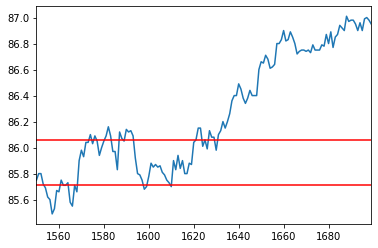

In [83]:
r = dataset.iloc[1550:1700]
ra = dataset.iloc[1550:1630, 8]
mean = ra.mean()
std = ra.std()
r['price_close'].plot()
plt.axhline(mean + std, color="red")
plt.axhline(mean - std, color="red")

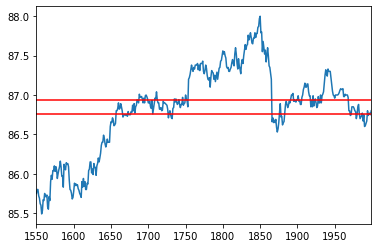

In [90]:
r = dataset.iloc[1550:2000]
ra = dataset.iloc[1650:1750, 8]
mean = ra.mean()
std = ra.std()
r['price_close'].plot()
plt.axhline(mean + std, color="red")
plt.axhline(mean - std, color="red")

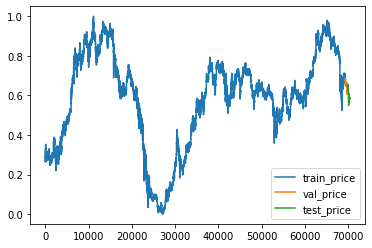

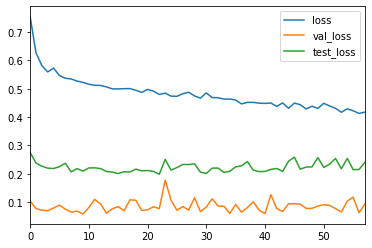

In [6]:
# Show data ranges
n_train, n_val, n_test = train_x.shape[0], train_params['n_val'], train_params['n_test']
plt.plot(np.arange(0, n_train), train_x[:, -1, 3], label='train_price')
plt.plot(np.arange(n_train, n_train+n_val), val_x[-n_test:, -1, 3], label='val_price')
plt.plot(np.arange(n_train+n_val, n_train+n_val+n_test), test_x[:, -1, 3], label='test_price')
plt.legend()
plt.show()

df = pd.read_csv(os.path.join(volume_dir, 'log_{}.csv'.format(scheme)))
df[['loss','val_loss', 'test_loss']].plot()

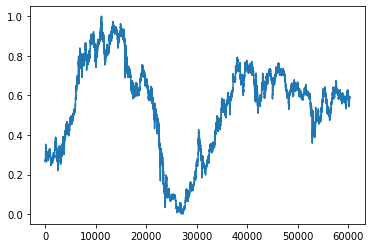

In [25]:
plt.plot(train_x[:100000, -1, 3])

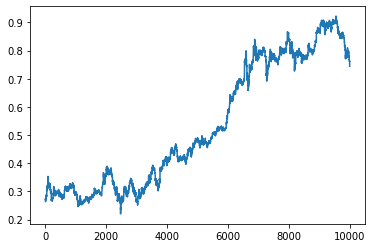

In [22]:
plt.plot(train_x[:10000, -1, 3])

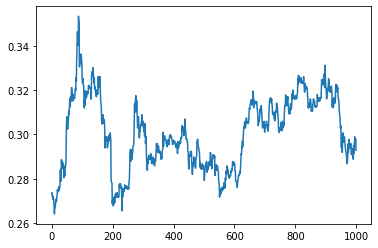

In [21]:
plt.plot(train_x[:1000, -1, 3])

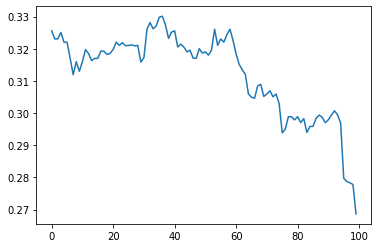

In [28]:
r = train_x[100:200, -1, 3]
plt.plot(r)

In [ ]:
model, _ = load_checkpoint_model(checkpoint_path, checkpoint_names)

x = test_xv
y = test_y
pred_y = model.predict(x)

In [ ]:
r = 3200
pad = 100
fromt = r - train_params['serie_len']
tot = r + train_params['serie_y_len']

fig, ax = plt.subplots(figsize=(16,5))
ax.plot(np.zeros(tot - fromt + pad*2), color='grey', linewidth=1)
ax.plot(pred_y[fromt - pad : tot + pad], label='pred', color='green', linewidth=3)
ax.plot(y[fromt - pad : tot + pad], label='truth', color='red', linewidth=3)
pc_ax = ax.twinx()
pc_ax.plot(x[fromt - pad : tot + pad, train_params['serie_len'] - 1, 0], label='price_close', color='grey', linewidth=1)
fig.legend()